# Zpětnovazební učení

V tomto cvičení budeme pracovat s knihovnou Gymnasium (udržovaný následovník knihovny Gym od OpenAI) - https://gymnasium.farama.org/, což je open source rozhraní určené pro úkoly zpětnovazebního učení. Jeho hlavní výhodou je, že implementace různých typů algoritmů pro zpětnovazební učení je v něm vcelku jednoduchá. Popis základních funkcí gymnasia se nachází v kódu níž.

Dnešní úkol bude naimplementovat agenta, který se učí chovat v nějakém prostředí (konkrétně v MountainCar) pomocí Q-učení.

Q-učení je způsob, kdy se agent učí svou strategii, jak se chovat v daném prostředí, pomocí zpětné vazby, kterou od prostředí za své chování dostává. Na rozdíl od hladového agenta (který jen v každém stavu vybírá nový stav na základě akce, co maximalizuje jeho užitek), bere v potaz to, že mezi stavy existují vztahy, které jsou dány Bellmanovými rovnicemi.

Nyní se tedy podíváme na příklad autíčka, které se snaží dostat do cíle, ale pohybuje se náhodně.

In [ ]:
import gymnasium
import utils
import numpy as np
import matplotlib.pyplot as plt

try:
    import pygame
except ImportError:
    pygame = None

Ukážeme si, jak si vytvořit jednoduché prostředí *MountainCar*: https://gymnasium.farama.org/environments/classic_control/mountain_car/

Cílem je, aby se autíčko dostalo z údolí až nahoru k vlaječce. V této základní verzi je zde v každém stavu náhodně zvolena akce pro pohyb.

(V následujícím kódu je zobrazování nastaveno tak, aby nám otevřelo prostředí v novém okně a v tom nám ukázalo běh agenta.)

In [3]:
env = gymnasium.make("MountainCar-v0", render_mode="human")

# Let's see, how the observation and action spaces of this environment look like
print("Observation space:", env.observation_space)
print("Observation space - low:", env.observation_space.low)
print("Observation space - high:", env.observation_space.high)
print("Action space:", env.action_space)

terminated, truncated = False, False
observation, info = env.reset()
while not terminated and not truncated:
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample()) # Take a random action
env.close()

Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Observation space - low: [-1.2  -0.07]
Observation space - high: [0.6  0.07]
Action space: Discrete(3)


Pokud bychom si prostředí chtěli vyzkoušet sami, dá se udělat třeba něco takového (není to sice zcela odladěné (hlavně nedržte víc kláves najednou), ale funguje to dostatečně):

(A ano, poběží to dokola, dokud to nevypnete...)

In [ ]:
if pygame is not None:
    # Initialize Pygame
    pygame.init()

    # Create a Pygame window
    screen = pygame.display.set_mode((640,  480))

    # Create the environment
    env = gymnasium.make("MountainCar-v0", render_mode="human")

    # Initialize variables
    env_terminated, done = False, False
    R = 0
    action_to_perform = 1

    # Reset the environment
    state = env.reset()

    # Define the mapping from keyboard keys to actions
    key_to_action = {
        pygame.K_LEFT:   0,  # Move cart left
        pygame.K_RIGHT:   2  # Move cart right
    }

    # Main loop
    while not env_terminated:
        # Process Pygame events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                env_terminated = True
                break
            
            elif event.type == pygame.KEYDOWN:
                if event.key in key_to_action:
                    action = key_to_action[event.key]
                    action_to_perform = action

            elif event.type == pygame.KEYUP:
                action_to_perform = 1 # Don't do anything

        if not env_terminated and not done:
            state, reward, terminated, truncated, info = env.step(action_to_perform)
            done = terminated or truncated
            R += reward

        if done:
            print("Return:", R)
            state = env.reset()
            done = False
            R = 0

        # Update the display
        pygame.display.flip()

    # Clean up
    env.close()
    pygame.quit()
    
else:
    print("This part is not available due to a missing optional dependency (pygame).")

Vraťme se zpět k agentům. Zkusíme do kódu výše připsat obecnou třídu pro agenta, který se v prostředí chová náhodně. Lze ho později použít jako základ pro zpětnovazebního agenta. Stav agenta je pozice a rychlost, akce může být akcelerace vlevo, vpravo a nebo nicnedělání. Budeme opakovat několik iterací pro "trénovaní", kdy každá iterace for cyklu je jedna hra s novým náhodným začátkem a ve while cyklu se trénují přechody mezi stavy agenta.

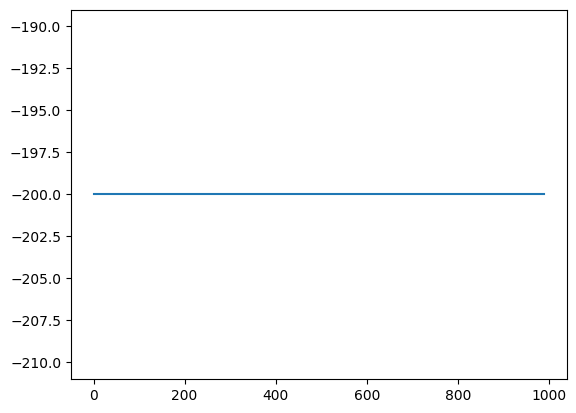

In [ ]:
# General class for a (random) agent
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.train = True
    
    def act(self, observation, reward, done):
        return self.action_space.sample()
    
    def reset(self):
        pass
    

env = gymnasium.make("MountainCar-v0")
agent = RandomAgent(env.action_space)

# Training loop (the agent trains for the duration of one thousand episodes)
agent.train = True
total_returns = []
for _ in range(1000):
    observation, _ = env.reset()
    agent.reset()    
    done = False
    
    reward = 0.
    R = 0. # Cummulative reward (otherwise known as return) - just for logging purposes
    timestep = 0 # Number of an iteration - here again just for possible logging purposes
    
    while not done:
        action = agent.act(observation, reward, done)
        observation, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        R += reward
        timestep += 1
        
    total_returns.append(R)
agent.train = False

# Let's show a plot of the learning and an animation (a simulation of the "trained" agent in the environmnet)
plt.plot(utils.moving_average(total_returns, 10))
plt.show()

# We pass only the name of the environment (and eventual arguments), not the environment itself, because we don't want to render
# anything during the training, but we want to do so during the test phase. This we achieve by creating a new environment
# for the testing / simulation with properly set render_mode argument (which we do inside the simulate function).
utils.simulate(agent, "MountainCar-v0", steps=200, episodes=1)

env.close()

## Úkol na cvičení

Zkuste si místo náhodného agenta naprogramovat třídu agenta, který se učí chovat v prostředí MountainCar pomocí Q-učení. Dejte pozor na to, že prostředí vrací jako stav spojité hodnoty, takže je třeba si z nich nějak udělat prostředí diskrétní (tedy s konečným množstvím stavů).

Níže je návrh obrysů takového agenta, který můžete případně použít.

In [ ]:
class QAgent:
    def __init__(self, action_space, epsilon, alpha, gamma):
        self.action_space = action_space
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
        self.train = True
        
        pass
        
        
    def _discretize(self, observation):
        """
        Discretization of the continuous state space
        """
        pass
    
    
    def act(self, observation, reward, done):
        """
        Acting in the environment with possible training
        """
        current_state = self._discretize(observation)
        
        if self.train:
            # Training
            pass
                
            # Action selection
            pass
                
            # Update of the inner memory for training
            pass
        
        else:
            pass
    
    
    def reset(self):
        """
        Reset of the inner memory
        """
        pass

In [ ]:
env = gymnasium.make("MountainCar-v0")

agent = QAgent(env.action_space)

# Training
agent.train = True
total_returns = []
for _ in range(1000):
    observation, _ = env.reset()
    agent.reset()
    done = False
    
    reward = 0.
    R = 0. # return
    timestep = 0
    
    while not done:
        action = agent.act(observation, reward, done)
        observation, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        R += reward
        timestep += 1
        
    total_returns.append(R)

env.close()

plt.plot(utils.moving_average(total_returns, 10))
plt.show()

# Evaluation
agent.train = False
print("Obtained returns:", utils.simulate(agent, "MountainCar-v0", steps=200, episodes=5))